In [1]:
import os
from typing import Callable, Dict

import matplotlib
import numpy as np
import pandas as pd
import scipy
from scipy import spatial
import seaborn as sns
import sklearn
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.preprocessing import normalize
from tqdm import tqdm
%matplotlib inline

In [2]:
DATA_DIR = "data/counts/matrices/"

In [3]:
mutations_df = pd.read_csv(
    "data/counts/matrices/sigmatrix_96.csv",
    index_col=0
)
mutations_df.shape

(96, 569)

In [4]:
mutations_df

DO217786  DO217787  DO217788  DO217800  DO217826  DO217844  \
MutationType                                                               
A[C>A]A            379       241       194        47       202       298   
A[C>A]C            249       140       291        61       181       146   
A[C>A]G             60        73        68        32        57       135   
A[C>A]T            249       175       242        19       123       139   
A[C>G]A             97       117       128        30        52       324   
...                ...       ...       ...       ...       ...       ...   
T[T>C]T            360       196       262        64       189       184   
T[T>G]A             96        58        92        14        28        62   
T[T>G]C             83        77        79         8        39        42   
T[T>G]G             95        58        51        12        64        63   
T[T>G]T            189       185       218        32       221       167   

              DO217865  DO217887  DO217907  DO217908  ...  DO225389  DO225390  \
MutationType                                          ...                       
A[C>A]A            373       135       396       184  ...       133       466   
A[C>A]C            239       156       548       158  ...       131       371   
A[C>A]G             47        30        75        14  ...        24        84   
A[C>A]T            109        55       301        83  ...       137       339   
A[C>G]A            118        42       258        73  ...       184       495   
...                ...       ...       ...       ...  ...       ...       ...   
T[T>C]T            166       128       664        73  ...       156       320   
T[T>G]A             52        52       190        42  ...       113       193   
T[T>G]C             31        13        72       145  ...        43       150   
T[T>G]G             29        51       116        39  ...        74       241   
T[T>G]T            186       140       314       110  ...       117       527   

              DO225391  DO225392  DO225393  DO225394  DO225395  DO225396  \
MutationType                                                               
A[C>A]A            264       187        81        60       316       159   
A[C>A]C             74       163       103        85       329       122   
A[C>A]G             38        23        53         5        55        11   
A[C>A]T            102       177        34        47       220       117   
A[C>G]A            230       159        42        59       364       106   
...                ...       ...       ...       ...       ...       ...   
T[T>C]T             63       232        44       104       502       122   
T[T>G]A             39       115        28        50       341        46   
T[T>G]C             30        33        23         8       451        21   
T[T>G]G             42        69        25         7       288        29   
T[T>G]T             74       296       100       115      3980        80   

              DO225397  DO225398  
MutationType                      
A[C>A]A            117       304  
A[C>A]C            100       327  
A[C>A]G             16        35  
A[C>A]T            154       294  
A[C>G]A             61       251  
...                ...       ...  
T[T>C]T            140       206  
T[T>G]A             76        97  
T[T>G]C             17        62  
T[T>G]G             23       172  
T[T>G]T            148       225  

[96 rows x 569 columns]

In [5]:
cosmic = pd.read_csv(
    "data/cosmic/COSMIC_v3.4_SBS_GRCh37.txt", sep="\t"
).rename(
    {"Type": "MutationType"}, axis="columns"
).set_index("MutationType")
cosmic.shape

(96, 86)

In [6]:
cosmic.head()

SBS1          SBS2      SBS3      SBS4      SBS5      SBS6  \
MutationType                                                                   
A[C>A]A       0.000886  5.800000e-07  0.020808  0.042196  0.011998  0.000425   
A[C>A]C       0.002280  1.480040e-04  0.016507  0.033297  0.009438  0.000524   
A[C>A]G       0.000177  5.230000e-05  0.001751  0.015599  0.001850  0.000052   
A[C>A]T       0.001280  9.780000e-05  0.012205  0.029498  0.006609  0.000180   
A[C>G]A       0.001860  2.230000e-16  0.019708  0.006889  0.010098  0.000471   

                 SBS7a     SBS7b     SBS7c     SBS7d  ...     SBS90     SBS91  \
MutationType                                          ...                       
A[C>A]A       0.000067  0.002329  0.004830  0.000040  ...  0.002202  0.002945   
A[C>A]C       0.000179  0.000461  0.001150  0.000765  ...  0.000708  0.052997   
A[C>A]G       0.000071  0.000186  0.000377  0.000250  ...  0.000139  0.000204   
A[C>A]T       0.000248  0.000710  0.001960  0.004049  ...  0.001755  0.000131   
A[C>G]A       0.000065  0.000009  0.001120  0.001180  ...  0.000508  0.000243   

                 SBS92     SBS93     SBS94     SBS95     SBS96     SBS97  \
MutationType                                                               
A[C>A]A       0.011329  0.011573  0.015580  0.038408  0.011431  0.008159   
A[C>A]C       0.009745  0.008096  0.024746  0.017384  0.007771  0.007513   
A[C>A]G       0.004697  0.001761  0.001574  0.008360  0.001997  0.001375   
A[C>A]T       0.007758  0.008421  0.011076  0.023294  0.011809  0.006858   
A[C>G]A       0.003056  0.008857  0.007004  0.003617  0.009295  0.002347   

                 SBS98     SBS99  
MutationType                      
A[C>A]A       0.008804  0.000004  
A[C>A]C       0.006769  0.000007  
A[C>A]G       0.032959  0.000051  
A[C>A]T       0.003758  0.000031  
A[C>G]A       0.006897  0.000446  

[5 rows x 86 columns]

In [7]:
np.all(mutations_df.index == cosmic.index)

True

In [8]:
cosmic.sum(axis="rows")

SBS1     1.0
SBS2     1.0
SBS3     1.0
SBS4     1.0
SBS5     1.0
        ... 
SBS95    1.0
SBS96    1.0
SBS97    1.0
SBS98    1.0
SBS99    1.0
Length: 86, dtype: float64

<Axes: ylabel='MutationType'>

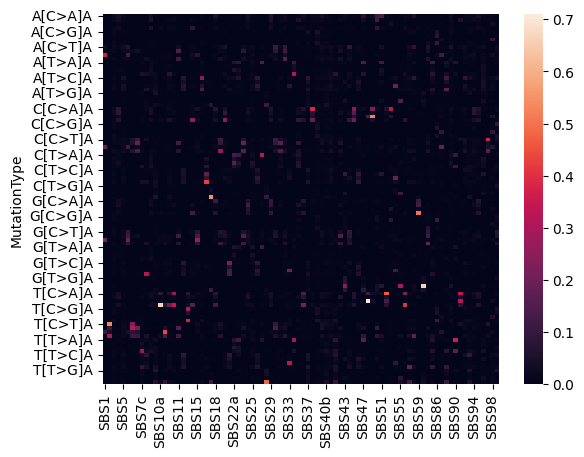

In [9]:
sns.heatmap(cosmic)

In [10]:
# cosmic.to_csv("data/cosmic/cosmic.csv", index=True)

In [11]:
default_rcparams = plt.rcParams

# Simple baselines
------------------------------


## 1. NMF

In [12]:
N_CATEGORIES, N_PATIENTS, N_SIGNATURES_COSMIC = *mutations_df.shape, cosmic.shape[1]
N_CATEGORIES, N_PATIENTS, N_SIGNATURES_COSMIC

(96, 569, 86)

### NMF under Frobenius norm
(optimal assuming Gaussian noise)

In [13]:
N_SIGNATURES = 10

In [14]:
mutations_np = mutations_df.transpose().to_numpy()
reconstruction_scores_nmf = []
absolute_errors_nmf = []
for i in tqdm(range(4, 21)):
    # NMF with Frobenius norm
    nmf = NMF(
        n_components=i,
        random_state=2137,
        init="nndsvd",
        solver="cd",
        beta_loss="frobenius",
        max_iter=10_000
    )
    E = nmf.fit_transform(mutations_df.transpose())
    P = nmf.components_
    reconstruction_scores_nmf.append(nmf.reconstruction_err_)
    absolute_errors_nmf.append(np.abs(E@P - mutations_np).mean())

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:08<00:00,  1.91it/s]


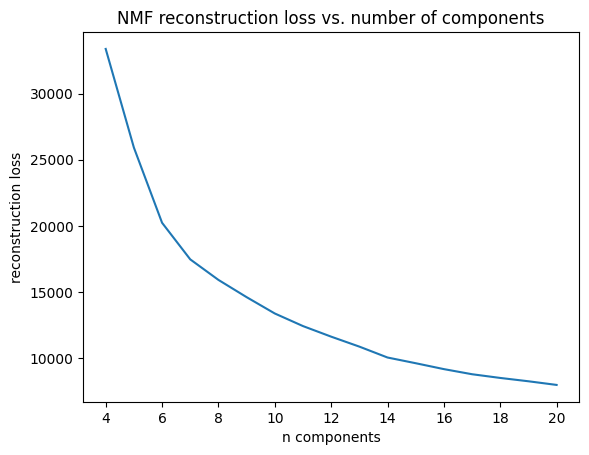

In [15]:
plt.plot(list(range(4, 21)), reconstruction_scores_nmf)
plt.xlabel("n components")
plt.ylabel("reconstruction loss")
plt.title("NMF reconstruction loss vs. number of components")
plt.show()

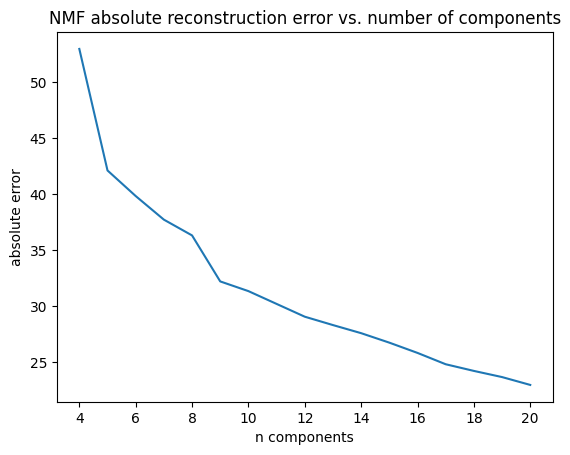

In [16]:
plt.plot(list(range(4, 21)), absolute_errors_nmf)
plt.xlabel("n components")
plt.ylabel("absolute error")
plt.title("NMF absolute reconstruction error vs. number of components")
plt.show()

In [14]:
# NMF with Frobenius norm
nmf = NMF(
    n_components=N_SIGNATURES,
    random_state=2137,
    init="nndsvd",
    solver="cd",
    beta_loss="frobenius",
    # alpha_W=0.00005,
    # alpha_H=0.00005,
    # l1_ratio=0.5,
    verbose=1,
    max_iter=10_000
)
E = nmf.fit_transform(mutations_df.transpose())
P = nmf.components_

violation: 1.0
violation: 0.4451173837337592
violation: 0.265937429264377
violation: 0.15369689961091687
violation: 0.0973697628642028
violation: 0.0675093966040305
violation: 0.052444250281131394
violation: 0.04346262427101101
violation: 0.03718324187186663
violation: 0.03258091841722073
violation: 0.029298462935825838
violation: 0.026733511269145752
violation: 0.024593861124517953
violation: 0.022967355710322986
violation: 0.02158314205796543
violation: 0.020309013183650634
violation: 0.019104323210542503
violation: 0.017945697561452173
violation: 0.01696693836999016
violation: 0.016027262051630357
violation: 0.0151458367838607
violation: 0.01436175621657156
violation: 0.013662447822978091
violation: 0.013011429417392601
violation: 0.012440712413169137
violation: 0.011899639648480762
violation: 0.011361453483588852
violation: 0.01091688219691017
violation: 0.010511675444177254
violation: 0.010167736885553311
violation: 0.00984404019346388
violation: 0.00953059479117245
violation: 0.0

In [15]:
E.shape, P.shape

((569, 10), (10, 96))

In [16]:
(E@P).shape

(569, 96)

In [17]:
nmf.reconstruction_err_

13385.41622971171

In [18]:
mutations_np = mutations_df.transpose().to_numpy()
np.abs(E@P - mutations_np).mean()

31.356575831536684

In [19]:
# nmf.feature_names_in_

<Axes: >

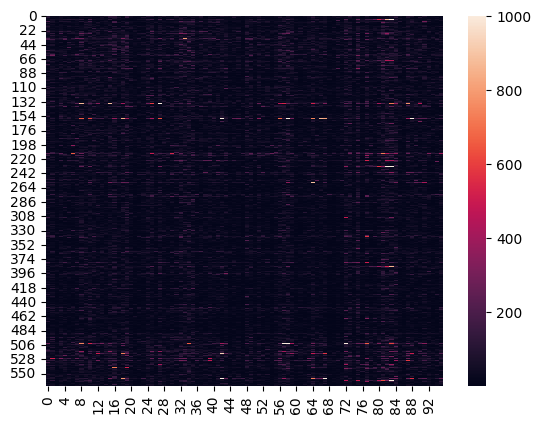

In [20]:
sns.heatmap(np.abs(E@P - mutations_np).clip(0, 1000))

In [21]:
P_prob = P / P.sum(axis=1, keepdims=True)
P_prob.shape

(10, 96)

In [22]:
cosmic.shape, P_prob.shape

((96, 86), (10, 96))

In [14]:
from src.utils.data_utils import get_nearest_signatures

In [24]:
nearest_signatures = get_nearest_signatures(P_prob, cosmic, scipy.spatial.distance.cosine)

In [25]:
list(nearest_signatures.items())

[(0, ('SBS2', 0.8655699691161407)),
 (1, ('SBS1', 0.9439888652253241)),
 (2, ('SBS13', 0.9827052112219459)),
 (3, ('SBS3', 0.8832700400315706)),
 (4, ('SBS44', 0.9690461939021949)),
 (5, ('SBS17b', 0.990683372204272)),
 (6, ('SBS26', 0.9584466631979277)),
 (7, ('SBS13', 0.7090407188409588)),
 (8, ('SBS40a', 0.7927810766572088)),
 (9, ('SBS2', 0.9570411243751918))]

In [26]:
discovered_signatures = pd.DataFrame(P_prob.transpose(), index=pd.Index(data=nmf.feature_names_in_, name="MutationType"))
discovered_signatures

0         1         2         3         4         5  \
MutationType                                                               
A[C>A]A       0.000519  0.001350  0.000000  0.021537  0.000000  0.005298   
A[C>A]C       0.000135  0.002766  0.000000  0.021889  0.000960  0.005034   
A[C>A]G       0.000248  0.000316  0.000000  0.004429  0.000000  0.000953   
A[C>A]T       0.000298  0.001270  0.000869  0.020721  0.006195  0.003671   
A[C>G]A       0.000410  0.000422  0.005670  0.028633  0.003247  0.007426   
...                ...       ...       ...       ...       ...       ...   
T[T>C]T       0.000000  0.025706  0.000000  0.010318  0.012992  0.007553   
T[T>G]A       0.000000  0.000411  0.001477  0.012405  0.000000  0.007818   
T[T>G]C       0.000000  0.000065  0.000422  0.006876  0.000000  0.010066   
T[T>G]G       0.000000  0.003591  0.000480  0.012850  0.000259  0.006608   
T[T>G]T       0.000000  0.006123  0.001912  0.015883  0.005448  0.091906   

                     6         7         8         9  
MutationType                                          
A[C>A]A       0.000000  0.000953  0.039959  0.002221  
A[C>A]C       0.000000  0.000000  0.029153  0.003815  
A[C>A]G       0.000000  0.001108  0.004935  0.000376  
A[C>A]T       0.000000  0.000000  0.020936  0.001421  
A[C>G]A       0.001978  0.009501  0.000200  0.000843  
...                ...       ...       ...       ...  
T[T>C]T       0.050331  0.001800  0.004182  0.002723  
T[T>G]A       0.002197  0.001815  0.003247  0.000897  
T[T>G]C       0.003343  0.000066  0.003483  0.001235  
T[T>G]G       0.005603  0.000413  0.001734  0.001603  
T[T>G]T       0.014478  0.000000  0.009814  0.002826  

[96 rows x 10 columns]

In [27]:
from sigProfilerPlotting import sigplot

discovered_plots = sigplot.plotSBS(discovered_signatures,
               "tmp/", "project", plot_type="96", savefig_format="pil_image", dpi=200, percentage=True
              )

OKAY 96
IS INSTANCE OF PANDAS!
GOT REF FORMAT
REINDEXED DATA
AFTER PROCESS_INPUT BEFORE REINDEX_SBS96
Length of figs: 10 WTF


In [15]:
plt.rcParams["figure.dpi"] = 240
plt.rcParams['figure.figsize'] = [6.4, 8]

In [31]:
fig, axs = plt.subplots(len(discovered_plots), 2)
fig.suptitle("Discovered signatures vs. cosine-nearest COSMIC signatures")
for i in range(len(discovered_plots)):
    axs[i,0].imshow(discovered_plots[i])
    axs[i,0].axis("off")
    # axs[i,0].set_xticks([])
    # axs[i,0].set_yticks([])
    axs[i,0].text(0.7, 0.7, f"cos similarity: {str(round(nearest_signatures[i][1], 2))}", size=8)
    axs[i,1].imshow(mpimg.imread(f"./data/cosmic/plots/{nearest_signatures[i][0]}.png"))
    axs[i,1].axis("off")
    # axs[i,1].set_xticks([])
    # axs[i,1].set_yticks([])
plt.savefig("NMF_DISCOVERED_CORR.png")

In [30]:
default_rcparams

RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': ['-layers', 'OptimizePlus'],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': 'line',
          'axes.edgecolor': 'black',
          'axes.facecolor': 'white',
          'axes.formatter.limits': [-5, 6],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
          'axes.formatter.useoffset': True,
          'axes.grid': False,
          'axes.grid.axis': 'both',
   

In [32]:
del fig, axs, discovered_plots
plt.clf()
plt.cla()
import gc
gc.collect()

32251

In [39]:
%reset_selective -f discovered_plots|fig|axs

In [33]:
gc.collect()

93

In [46]:
# who_ls

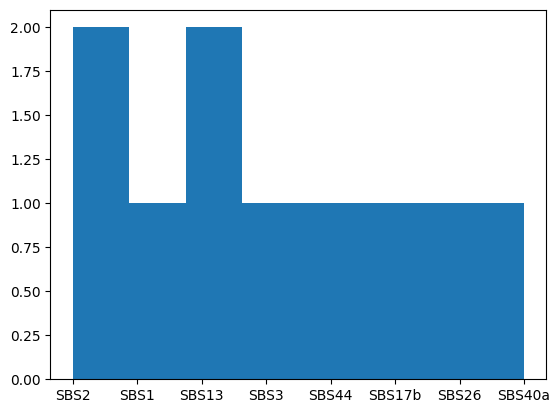

In [35]:
import matplotlib
%matplotlib inline
import seaborn
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
# sns.countplot(nearest_signatures.values())
plt.hist(nearest_signatures.values(), bins=len(set(nearest_signatures.values())))
plt.show()

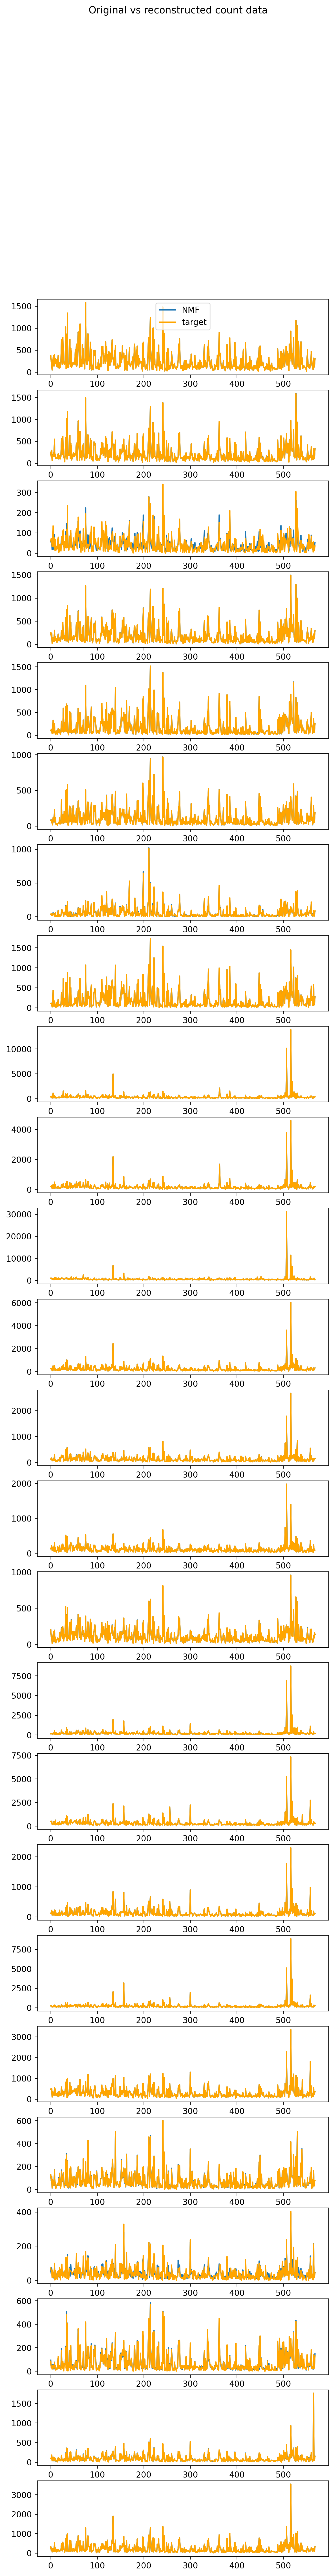

In [24]:
n_plots = 25
fig, axs = plt.subplots(n_plots, 1)
fig.suptitle("Original vs reconstructed count data")
for i in range(n_plots):
    axs[i].plot(E@P[:,i], label="NMF")
    axs[i].plot(mutations_np[:,i], color="orange", label="target")
    if i == 0:
        axs[i].legend()

# 2. LDA

In [59]:
perplexity_scores_lda = []
absolute_errors_lda = []

for i in tqdm(range(4, 21)):
    lda = LatentDirichletAllocation(
        n_components=i,
        max_iter=1000,
        learning_method="batch",
        learning_offset=10.0,
        perp_tol=1e-3,
        random_state=2137,
        n_jobs=-1,
        evaluate_every=10
    )
    E = lda.fit_transform(mutations_df.transpose())
    P = lda.components_
    P_prob_lda = lda.components_ / lda.components_.sum(axis=1, keepdims=True)
    perplexity_scores_lda.append(lda.perplexity(mutations_df.transpose()))
    absolute_errors_lda.append(np.abs(E@P - mutations_np).mean())

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [05:21<00:00, 18.94s/it]


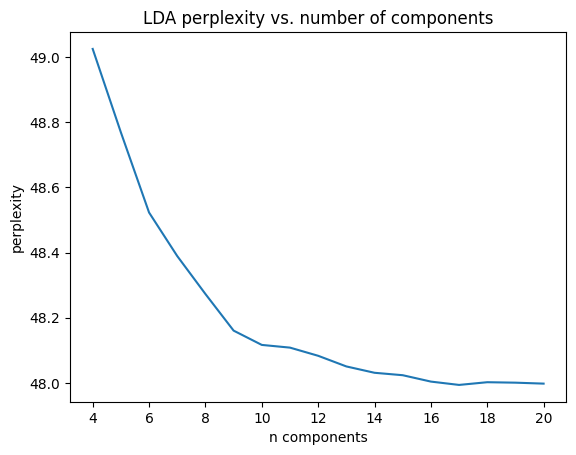

In [60]:
plt.plot(list(range(4, 21)), perplexity_scores_lda)
plt.xlabel("n components")
plt.ylabel("perplexity")
plt.title("LDA perplexity vs. number of components")
plt.show()

In [62]:
perplexity_scores_lda = []
absolute_errors_lda = []

for i in tqdm(range(4, 41, 2)):
    lda = LatentDirichletAllocation(
        n_components=i,
        max_iter=1000,
        learning_method="batch",
        learning_offset=10.0,
        perp_tol=1e-3,
        random_state=2137,
        n_jobs=-1,
        evaluate_every=10
    )
    E = lda.fit_transform(mutations_df.transpose())
    P = lda.components_
    P_prob_lda = lda.components_ / lda.components_.sum(axis=1, keepdims=True)
    perplexity_scores_lda.append(lda.perplexity(mutations_df.transpose()))
    absolute_errors_lda.append(np.abs(E@P - mutations_np).mean())

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [08:38<00:00, 27.27s/it]


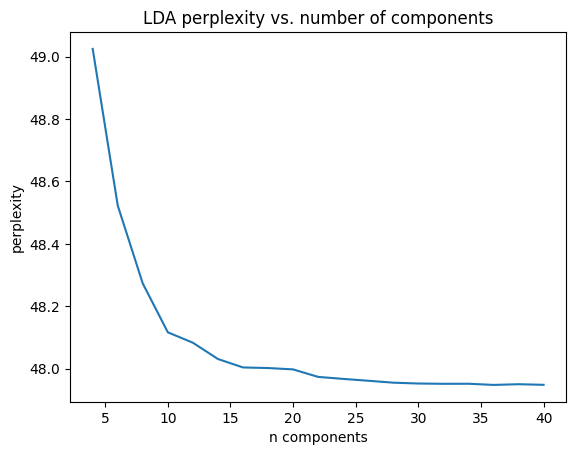

In [63]:
plt.plot(list(range(4, 41, 2)), perplexity_scores_lda)
plt.xlabel("n components")
plt.ylabel("perplexity")
plt.title("LDA perplexity vs. number of components")
plt.show()

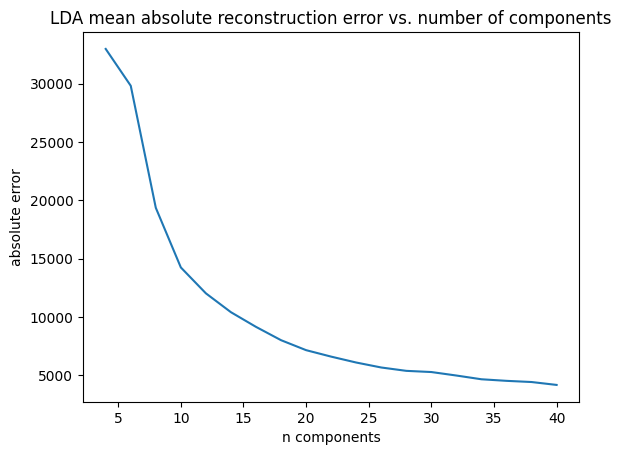

In [64]:
plt.plot(list(range(4, 41, 2)), absolute_errors_lda)
plt.xlabel("n components")
plt.ylabel("absolute error")
plt.title("LDA mean absolute reconstruction error vs. number of components")
plt.show()

In [16]:
# LDA
lda = LatentDirichletAllocation(
    n_components=10,
    max_iter=1000,
    learning_method="batch",
    # learning_offset=10.0,
    # learning_decay=0.7,
    perp_tol=1e-3,
    random_state=2137,
    n_jobs=-1,
    evaluate_every=10,
    verbose=1
)
E = lda.fit_transform(mutations_df.transpose())
P = lda.components_
P_prob_lda = lda.components_ / lda.components_.sum(axis=1, keepdims=True)

iteration: 1 of max_iter: 1000
iteration: 2 of max_iter: 1000
iteration: 3 of max_iter: 1000
iteration: 4 of max_iter: 1000
iteration: 5 of max_iter: 1000
iteration: 6 of max_iter: 1000
iteration: 7 of max_iter: 1000
iteration: 8 of max_iter: 1000
iteration: 9 of max_iter: 1000
iteration: 10 of max_iter: 1000, perplexity: 48.4990
iteration: 11 of max_iter: 1000
iteration: 12 of max_iter: 1000
iteration: 13 of max_iter: 1000
iteration: 14 of max_iter: 1000
iteration: 15 of max_iter: 1000
iteration: 16 of max_iter: 1000
iteration: 17 of max_iter: 1000
iteration: 18 of max_iter: 1000
iteration: 19 of max_iter: 1000
iteration: 20 of max_iter: 1000, perplexity: 48.3292
iteration: 21 of max_iter: 1000
iteration: 22 of max_iter: 1000
iteration: 23 of max_iter: 1000
iteration: 24 of max_iter: 1000
iteration: 25 of max_iter: 1000
iteration: 26 of max_iter: 1000
iteration: 27 of max_iter: 1000
iteration: 28 of max_iter: 1000
iteration: 29 of max_iter: 1000
iteration: 30 of max_iter: 1000, perple

In [35]:
E.shape, P.shape

((569, 10), (10, 96))

In [36]:
np.linalg.norm(((E @ P) - mutations_df.transpose()), "fro")

6314992.531438986

In [37]:
np.abs(E@P - mutations_np).mean()

14240.302022890071

In [17]:
nearest_signatures_lda = get_nearest_signatures(P_prob_lda, cosmic)

In [22]:
discovered_signatures_lda = pd.DataFrame(P_prob_lda.transpose(), index=cosmic.index)
discovered_signatures_lda

0         1         2         3         4             5  \
MutationType                                                                   
A[C>A]A       0.009826  0.001643  0.002457  0.033832  0.003962  6.270328e-04   
A[C>A]C       0.009085  0.001724  0.005881  0.032872  0.004312  3.037256e-04   
A[C>A]G       0.003896  0.000010  0.000500  0.003114  0.000432  3.748100e-04   
A[C>A]T       0.010518  0.001887  0.001636  0.030372  0.002747  1.481486e-04   
A[C>G]A       0.033164  0.004129  0.000545  0.011088  0.004755  1.015784e-03   
...                ...       ...       ...       ...       ...           ...   
T[T>C]T       0.011523  0.001003  0.022625  0.008077  0.007081  1.498357e-06   
T[T>G]A       0.013814  0.001177  0.000709  0.003433  0.006219  4.364552e-08   
T[T>G]C       0.007113  0.000564  0.000747  0.003020  0.009361  4.364569e-08   
T[T>G]G       0.013160  0.000566  0.005330  0.007053  0.006327  2.042962e-05   
T[T>G]T       0.018249  0.001707  0.008148  0.008732  0.097638  4.364548e-08   

                         6         7         8         9  
MutationType                                              
A[C>A]A       1.032580e-07  0.032386  0.017134  0.003225  
A[C>A]C       1.032605e-07  0.018315  0.015025  0.003028  
A[C>A]G       1.032565e-07  0.004297  0.004808  0.000602  
A[C>A]T       3.830507e-03  0.014480  0.007648  0.001402  
A[C>G]A       2.267269e-03  0.002317  0.005943  0.001957  
...                    ...       ...       ...       ...  
T[T>C]T       2.027674e-02  0.005391  0.004388  0.049520  
T[T>G]A       1.032606e-07  0.003901  0.007543  0.002641  
T[T>G]C       1.032587e-07  0.002607  0.006212  0.003915  
T[T>G]G       1.240367e-03  0.002224  0.002285  0.005251  
T[T>G]T       5.211749e-03  0.009934  0.012024  0.015139  

[96 rows x 10 columns]

In [23]:
from sigProfilerPlotting import sigplot

discovered_plots = sigplot.plotSBS(discovered_signatures_lda,
               "tmp/", "project", plot_type="96", savefig_format="pil_image", dpi=200, percentage=True
)

OKAY 96
IS INSTANCE OF PANDAS!
GOT REF FORMAT
REINDEXED DATA
AFTER PROCESS_INPUT BEFORE REINDEX_SBS96
Length of figs: 10 WTF


In [24]:
plt.rcParams["figure.dpi"] = 240
plt.rcParams['figure.figsize'] = [6.4, 8]

In [25]:
fig, axs = plt.subplots(len(discovered_plots), 2)
fig.suptitle("LDA-discovered signatures vs. their cosine-nearest COSMIC signatures")
for i in range(len(discovered_plots)):
    axs[i,0].imshow(discovered_plots[i])
    axs[i,0].axis("off")
    axs[i,0].text(0.7, 0.7, f"cos similarity: {str(round(nearest_signatures_lda[i][1], 2))}", size=6)
    axs[i,1].imshow(mpimg.imread(f"./data/cosmic/plots/{nearest_signatures_lda[i][0]}.png"))
    axs[i,1].axis("off")
plt.savefig("LDA_DISCOVERED_CORR.png")

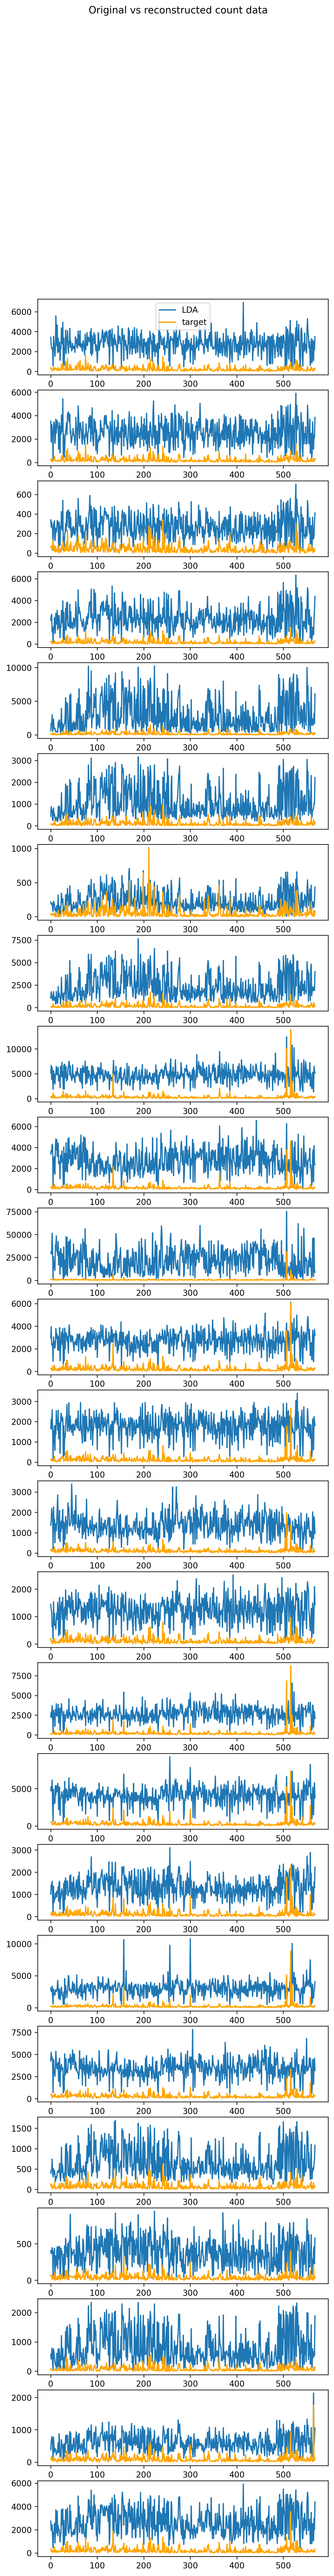

In [123]:
plt.rcParams["figure.dpi"] = 240
plt.rcParams['figure.figsize'] = [6.4, 50]

n_plots = 25
fig, axs = plt.subplots(n_plots, 1)
fig.suptitle("Original vs reconstructed count data")
for i in range(n_plots):
    axs[i].plot((E@P)[:,i], label="LDA")
    axs[i].plot(mutations_np[:,i], color="orange", label="target")
    if i == 0:
        axs[i].legend()